## Author -Akash gupta

### TASK

### *Stock Market Prediction Using Numerical and Textual Analysis*

### OBJECTIVE:

Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines.

We will be using Recurrent Neural Networks with LSTM Sequential Model.

## The Project was split into:

1 Creating the data frame for close price. We will only use Close price for this model.

2 Scaling the data. We will be using MinMaxScaler.(It will scale data in range[0,1]).

3 Reshaping the training data which can be used in the LSTM Model.

4 Compile the Model.

5 Preparing the test data, feature scaling and reshaping.

6 Predicting the output from the test data.

7 Scaling the data back to the original format.

8 Using polarity and subjectivity scores of TextBlob on the given news dataframe to train it on various models with
  closing price as predictor output.
  
9 Comparing our model's prediction with the actual closing price.


In [1]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense, LSTM
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import re
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import xgboost

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\akash\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Step 1 : Importing the Numerical dataset and performing Exploratory Analysis

In [2]:
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
# For time stamps
from datetime import datetime

In [3]:
# Dataframe for exploratory analysis
df=pd.read_csv('^BSESN.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-14,24606.199219,25018.460938,24473.220703,24772.970703,24772.970703,14900.0
1,2016-01-15,24881.759766,24912.640625,24421.529297,24455.039063,24455.039063,12700.0
2,2016-01-18,24400.779297,24524.849609,24141.990234,24188.369141,24188.369141,13600.0
3,2016-01-19,24257.279297,24563.339844,24247.230469,24479.839844,24479.839844,9400.0
4,2016-01-20,24325.769531,24325.769531,23839.759766,24062.039063,24062.039063,12800.0


In [4]:
df=df[["Date","Open","High","Low","Close","Volume"]]
df.head(-5)

,Date,Open,High,Low,Close,Volume
0,2016-01-14,24606.199219,25018.460938,24473.220703,24772.970703,14900.0
1,2016-01-15,24881.759766,24912.640625,24421.529297,24455.039063,12700.0
2,2016-01-18,24400.779297,24524.849609,24141.990234,24188.369141,13600.0
3,2016-01-19,24257.279297,24563.339844,24247.230469,24479.839844,9400.0
4,2016-01-20,24325.769531,24325.769531,23839.759766,24062.039063,12800.0
...,...,...,...,...,...,...
1260,2021-02-22,50910.511719,50986.031250,49617.371094,49744.320313,16300.0
1261,2021-02-23,49994.851563,50327.308594,49659.851563,49751.410156,14900.0
1262,2021-02-24,49763.941406,50881.171875,49648.781250,50781.691406,45900.0
1263,2021-02-25,51207.609375,51386.121094,50991.761719,51039.308594,33500.0


In [5]:
# Check for common information of the second dataset
df["Date"]= pd.to_datetime(df["Date"])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 6 columns):
Date      1270 non-null datetime64[ns]
Open      1265 non-null float64
High      1265 non-null float64
Low       1265 non-null float64
Close     1265 non-null float64
Volume    1265 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 59.7 KB


C:\Users\akash\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


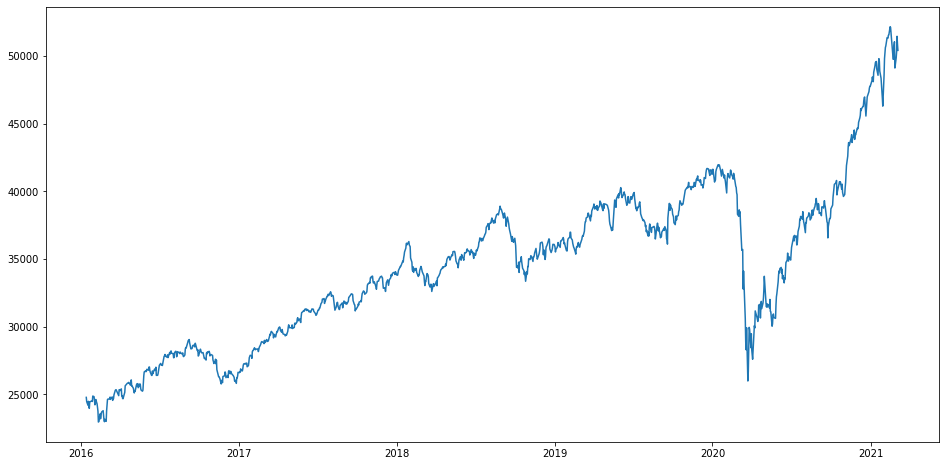

In [6]:
# Extract date frame and plot closing stock price w.r.t time
df.index = df['Date']
df.dropna(inplace=True)
#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [7]:
# fix random seed for reproducibility
np.random.seed(7)

### Step 2 : Creating a dataframe for storing the Closing stock data per day

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(df2, look_back=1):
	dataX, dataY = [], []
	for i in range(len(df2)-look_back-1):
		a = df2[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(df2[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [9]:
df2 = pd.read_csv('^BSESN.csv', usecols=[5], engine='python')
df2.dropna(inplace=True)
df2 = df2.values
df2 = df2.astype('float32')

### Step 3 : Data Normalization and Division into Training and Test sets¶


In [25]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
df2 = scaler.fit_transform(df2)

# split into train and test sets
train_size = int(len(df2) * 0.67)
test_size = len(df2) - train_size
train, test = df2[0:train_size,:], df2[train_size:len(df2),:]

In [26]:
# reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [27]:
trainX.shape,testX.shape

((842, 4, 1), (413, 4, 1))

In [28]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=2, verbose=2)

Epoch 1/15
 - 3s - loss: 0.0036
Epoch 2/15
 - 1s - loss: 1.7428e-04
Epoch 3/15
 - 2s - loss: 1.6587e-04
Epoch 4/15
 - 2s - loss: 1.6497e-04
Epoch 5/15
 - 2s - loss: 1.6587e-04
Epoch 6/15
 - 2s - loss: 1.6680e-04
Epoch 7/15
 - 1s - loss: 1.6616e-04
Epoch 8/15
 - 1s - loss: 1.7352e-04
Epoch 9/15
 - 1s - loss: 1.5949e-04
Epoch 10/15
 - 1s - loss: 1.5867e-04
Epoch 11/15
 - 1s - loss: 1.6620e-04
Epoch 12/15
 - 1s - loss: 1.6706e-04
Epoch 13/15
 - 1s - loss: 1.5840e-04
Epoch 14/15
 - 2s - loss: 1.6558e-04
Epoch 15/15
 - 2s - loss: 1.7346e-04


In [29]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainP=trainPredict
testP=testPredict

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

### Step 5 : Making Predictions

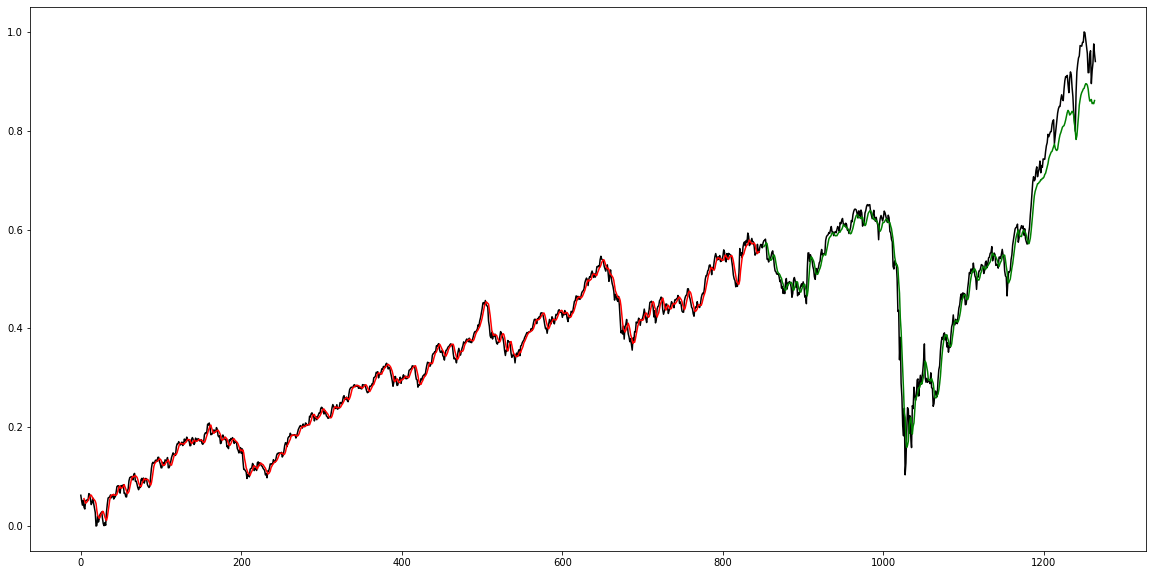

In [30]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df2)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize = (20,10))
plt.plot(scaler.inverse_transform(df2),color='black')
plt.plot(trainPredictPlot,color='red')
plt.plot(testPredictPlot,color='green')
plt.show()

In [31]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print("Root mean square error = ",trainScore," RMSE")
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print("Root mean square error = ",testScore," RMSE")

Root mean square error =  0.01163329376017549  RMSE
Root mean square error =  0.03795225110365662  RMSE


In [32]:
# Load the news dataset
columns=['Date','Category','News']
ndf = pd.read_csv("india-news-headlines.csv",names=columns)

C:\Users\akash\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
print('Showing part of the whole dataset:')
ndf.head(5)

Showing part of the whole dataset:


,Date,Category,News
0,publish_date,headline_category,headline_text
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


In [34]:
ndf.drop(0, inplace=True)
ndf.drop('Category', axis = 1, inplace=True)
print('Showing part of the whole dataset:')
ndf.head(-5)

Showing part of the whole dataset:


,Date,News
1,20010102,Status quo will not be disturbed at Ayodhya; s...
2,20010102,Fissures in Hurriyat over Pak visit
3,20010102,America's unwanted heading for India?
4,20010102,For bigwigs; it is destination Goa
5,20010102,Extra buses to clear tourist traffic
...,...,...
3424058,20201231,50 NRIs reach Singhu; offer help to farmers
3424059,20201231,Navjot Singh Sidhu tweets apology; says 'wore ...
3424060,20201231,Azim Premji organisation's name misused to che...
3424061,20201231,Get govt nod to probe officials: MP to agencies


In [35]:
# Check for common information of the news datast
ndf["Date"] = pd.to_datetime(ndf["Date"],format='%Y%m%d')
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3424067 entries, 1 to 3424067
Data columns (total 2 columns):
Date    datetime64[ns]
News    object
dtypes: datetime64[ns](1), object(1)
memory usage: 78.4+ MB


In [36]:
# Group the headlines for each day
ndf['News'] = ndf.groupby(['Date']).transform(lambda x : ' '.join(x)) 
ndf = ndf.drop_duplicates() 
ndf.reset_index(inplace=True,drop=True)

In [39]:
ndf

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [40]:
# Check for any duplicated values
ndf.isnull().sum()

Date    0
News    0
dtype: int64

### Remove Unwanted Characters from the News

In [41]:
#removing unwanted characters from the News
ndf.replace("[^a-zA-Z']"," ",regex=True,inplace=True)
ndf["News"].head(5)

0    Status quo will not be disturbed at Ayodhya  s...
1    Powerless north India gropes in the dark Think...
2    The string that pulled Stephen Hawking to Indi...
3    Light combat craft takes India into club class...
4    Light combat craft takes India into club class...
Name: News, dtype: object

## Textual Analysis

In [42]:
#Functions to get the subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [43]:
#Adding subjectivity and polarity columns
ndf['Subjectivity'] = ndf['News'].apply(getSubjectivity)
ndf['Polarity'] = ndf['News'].apply(getPolarity)
ndf

,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


### Visualizing the polarity and Subjectivity scores¶


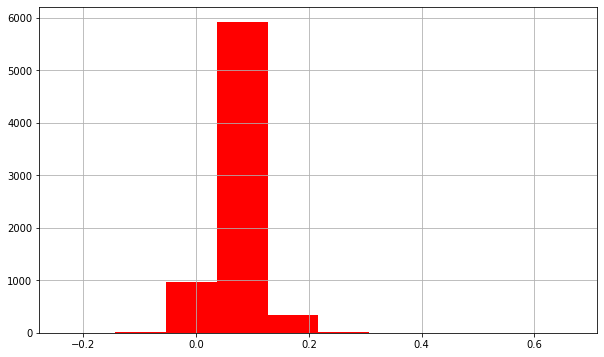

In [58]:
plt.figure(figsize = (10,6))
ndf['Polarity'].hist(color = 'red')

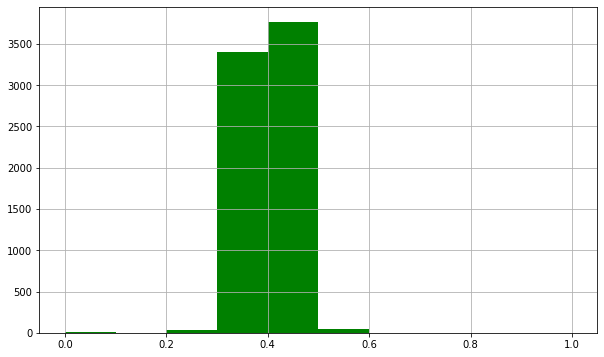

In [59]:
plt.figure(figsize = (10,6))
ndf['Subjectivity'].hist(color = 'green')

In [147]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

In [ ]:
ndf['Compound'] = [sia.polarity_scores(v)['compound'] for v in ndf['News']]
ndf['Negative'] = [sia.polarity_scores(v)['neg'] for v in ndf['News']]
ndf['Neutral'] = [sia.polarity_scores(v)['neu'] for v in ndf['News']]
ndf['Positive'] = [sia.polarity_scores(v)['pos'] for v in ndf['News']]
ndf

In [45]:
df=pd.read_csv('^BSESN.csv')
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-14,24606.199219,25018.460938,24473.220703,24772.970703,24772.970703,14900.0
1,2016-01-15,24881.759766,24912.640625,24421.529297,24455.039063,24455.039063,12700.0
2,2016-01-18,24400.779297,24524.849609,24141.990234,24188.369141,24188.369141,13600.0
3,2016-01-19,24257.279297,24563.339844,24247.230469,24479.839844,24479.839844,9400.0
4,2016-01-20,24325.769531,24325.769531,23839.759766,24062.039063,24062.039063,12800.0


In [46]:
df_merge = pd.merge(df, ndf, how='inner', on='Date')
df_merge

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity
0,2016-01-14,24606.199219,25018.460938,24473.220703,24772.970703,24772.970703,14900.0,Foods women must eat to fight osteoporosis Bes...,0.378881,0.064791
1,2016-01-15,24881.759766,24912.640625,24421.529297,24455.039063,24455.039063,12700.0,Common fitness mistakes women keep making Fres...,0.401473,0.048803
2,2016-01-18,24400.779297,24524.849609,24141.990234,24188.369141,24188.369141,13600.0,Exercising through injury Tips to understand f...,0.406078,0.127363
3,2016-01-19,24257.279297,24563.339844,24247.230469,24479.839844,24479.839844,9400.0,superfoods for your child All you wanted to ...,0.375585,0.063907
4,2016-01-20,24325.769531,24325.769531,23839.759766,24062.039063,24062.039063,12800.0,Everyday habits that could be ruining your ski...,0.380043,0.059517
...,...,...,...,...,...,...,...,...,...,...
1216,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539063,46973.539063,13700.0,How to set the mood for sex during cold winter...,0.387011,0.053569
1217,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600.0,Horoscope Today December Check astro...,0.409973,0.071405
1218,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800.0,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
1219,2020-12-30,47789.031250,47807.851563,47358.359375,47746.218750,47746.218750,15600.0,Numerology Readings December Predicti...,0.436863,0.046930


In [48]:
dfmerge1 = df_merge[['Close','Subjectivity', 'Polarity']]
dfmerge1

,Close,Subjectivity,Polarity
0,24772.970703,0.378881,0.064791
1,24455.039063,0.401473,0.048803
2,24188.369141,0.406078,0.127363
3,24479.839844,0.375585,0.063907
4,24062.039063,0.380043,0.059517
...,...,...,...
1216,46973.539063,0.387011,0.053569
1217,47353.750000,0.409973,0.071405
1218,47613.078125,0.415684,0.060775
1219,47746.218750,0.436863,0.046930


### Normalize Data

In [49]:
scaler = MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(dfmerge1))
df.columns = dfmerge1.columns
df.index = dfmerge1.index
df.head()

,Close,Subjectivity,Polarity
0,0.073435,0.364022,0.545935
1,0.060614,0.534789,0.429917
2,0.049861,0.569601,1.000000
3,0.061615,0.339110,0.539524
4,0.044767,0.372802,0.507664


In [50]:
X=df.drop('Close',axis=1)
X

,Subjectivity,Polarity
0,0.364022,0.545935
1,0.534789,0.429917
2,0.569601,1.000000
3,0.339110,0.539524
4,0.372802,0.507664
...,...,...
1216,0.425477,0.464499
1217,0.599046,0.593934
1218,0.642216,0.516791
1219,0.802298,0.416327


In [51]:
Y=df['Close']
Y

0       0.073435
1       0.060614
2       0.049861
3       0.061615
4       0.044767
          ...   
1216    0.968637
1217    0.983968
1218    0.994425
1219    0.999794
1220    1.000000
Name: Close, Length: 1221, dtype: float64

### Split the Dataset into Train & Test Data

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
x_train.shape

(976, 2)

In [55]:
x_train[:10]

,Subjectivity,Polarity
546,0.534676,0.391622
902,0.344587,0.389584
1037,0.467706,0.752185
422,0.418639,0.572040
85,0.537956,0.670260
192,0.261131,0.485215
833,0.426555,0.606032
513,0.454391,0.415819
587,0.669219,0.461066
1010,0.494020,0.459337


### RandomForestRegressor Model

In [56]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)
prediction=rf.predict(x_test)

In [57]:
print(prediction[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(prediction,y_test))

[0.61818577 0.57160357 0.50820724 0.58528128 0.58892033 0.36151083
 0.51198487 0.40925041 0.31869987 0.51342439]
1146    0.637303
992     0.724288
478     0.436523
161     0.235707
1155    0.582142
989     0.734019
568     0.482411
5       0.040742
805     0.649322
552     0.443098
Name: Close, dtype: float64
Mean Squared error:  0.04679356120046397


### AdaBoostRegressor Model

In [60]:
adb = AdaBoostRegressor()
adb.fit(x_train, y_train)

AdaBoostRegressor()

In [61]:
predictions = adb.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.04227648030732999


### LGBMRegressor Model

In [67]:
import lightgbm

In [68]:
gbm = lightgbm.LGBMRegressor()
gbm.fit(x_train, y_train)

LGBMRegressor()

In [69]:
predictions = gbm.predict(x_test)
print(mean_squared_error(predictions, y_test))

0.04854315367262096


### DecisionTreeRegressor Model

In [63]:
from sklearn.tree import DecisionTreeRegressor

In [64]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train)
predictions = dtr.predict(x_test)

In [65]:
print(predictions[:10])
print(y_test[:10])
print('Mean Squared error: ',mean_squared_error(predictions,y_test))

[0.96811884 0.59321757 0.61191755 0.66464606 0.89226486 0.52115525
 0.65207493 0.06884818 0.38561705 0.74147993]
1146    0.637303
992     0.724288
478     0.436523
161     0.235707
1155    0.582142
989     0.734019
568     0.482411
5       0.040742
805     0.649322
552     0.443098
Name: Close, dtype: float64
Mean Squared error:  0.07585266350843006


                           Mean Squared Error 
DecisionTree-----------------> 0.07585266350843006

AdaBoostRegressor--------> 0.04227648030732999

LightGBM--------------------> 0.04854315367262096

LGBMRegressor-----------> 0.04854315367262096

We can see that AdaBoostRegressor Model shows a slightly better performance than the others